In [1]:
%matplotlib inline

import json
import tqdm
from datetime import datetime as dt
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pickle
from dateutil.parser import parse
import seaborn as sns

In [3]:
mintstp=None
maxtstp=None
minbandwidth=None
maxbandwidth=None
minfrequency=None
maxfrequency=None
ignored_timestamps = 0

packets = []
timestamps = []
bws = []
freqs = []

with open('/home/rgopikrishna/vrif_working/data/newomnisig-kop-*_8apr21to8jun21_signalsseperated/filteredpackets_fm_8apr21to8jun21.json') as f:
    for idx,line in enumerate(f):
        pkt = json.loads(line)
        packets.append(pkt)
        try:
            tstp = parse(pkt['timestamp'])  
        except ValueError:
            ignored_timestamps+=1
            continue
            
        bw = float(pkt['bandwidth'])
        freq = float(pkt['frequency'])
        timestamps.append(tstp)
        bws.append(bw)
        freqs.append(freq)
        
        
print("Num Ignored Packets = {}".format(ignored_timestamps))

Num Ignored Packets = 0


In [4]:
mintstp = min(timestamps)
maxtstp = max(timestamps)
minbandwidth = min(bws)
maxbandwidth = max(bws)
minfrequency = min(freqs)
maxfrequency = max(freqs)

In [5]:
print("Min Tstp {} \nMax Tstp {}\nMin Bandwidth {}\nMax Bandwidth {}\nMin Freq. {}\nMax Freq. {}".format(
                                                                          mintstp,maxtstp,
                                                                          minbandwidth,maxbandwidth,
                                                                          minfrequency,maxfrequency))

Min Tstp 2021-04-08 04:00:05.316094+00:00 
Max Tstp 2021-06-08 03:59:58.417635+00:00
Min Bandwidth 9765.625
Max Bandwidth 20268380.641937256
Min Freq. 800302734.375
Max Freq. 5352919921.875


Text(0.5, 1.0, 'packet counts per day')

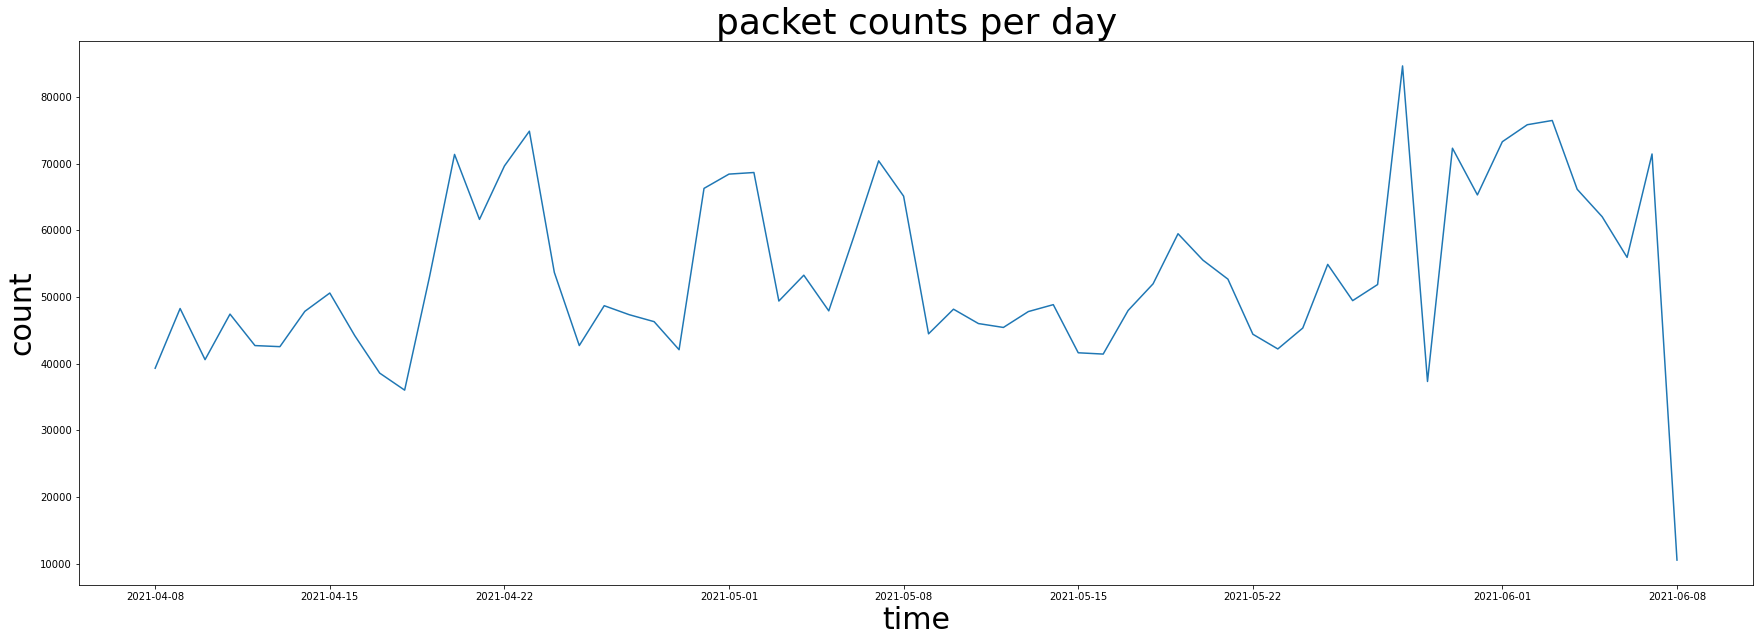

In [6]:
ax = pd.Series([ts.date() for ts in timestamps]).value_counts().plot(figsize=(30,10))
plt.rcParams.update({'font.size': 30})
ax.set_xlabel('time',fontsize=30)
ax.set_ylabel('count',fontsize=30)
ax.set_title('packet counts per day')

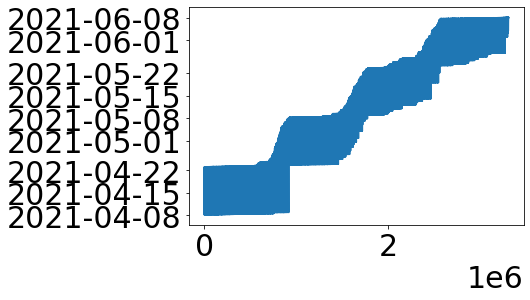

In [7]:
plt.plot(timestamps)

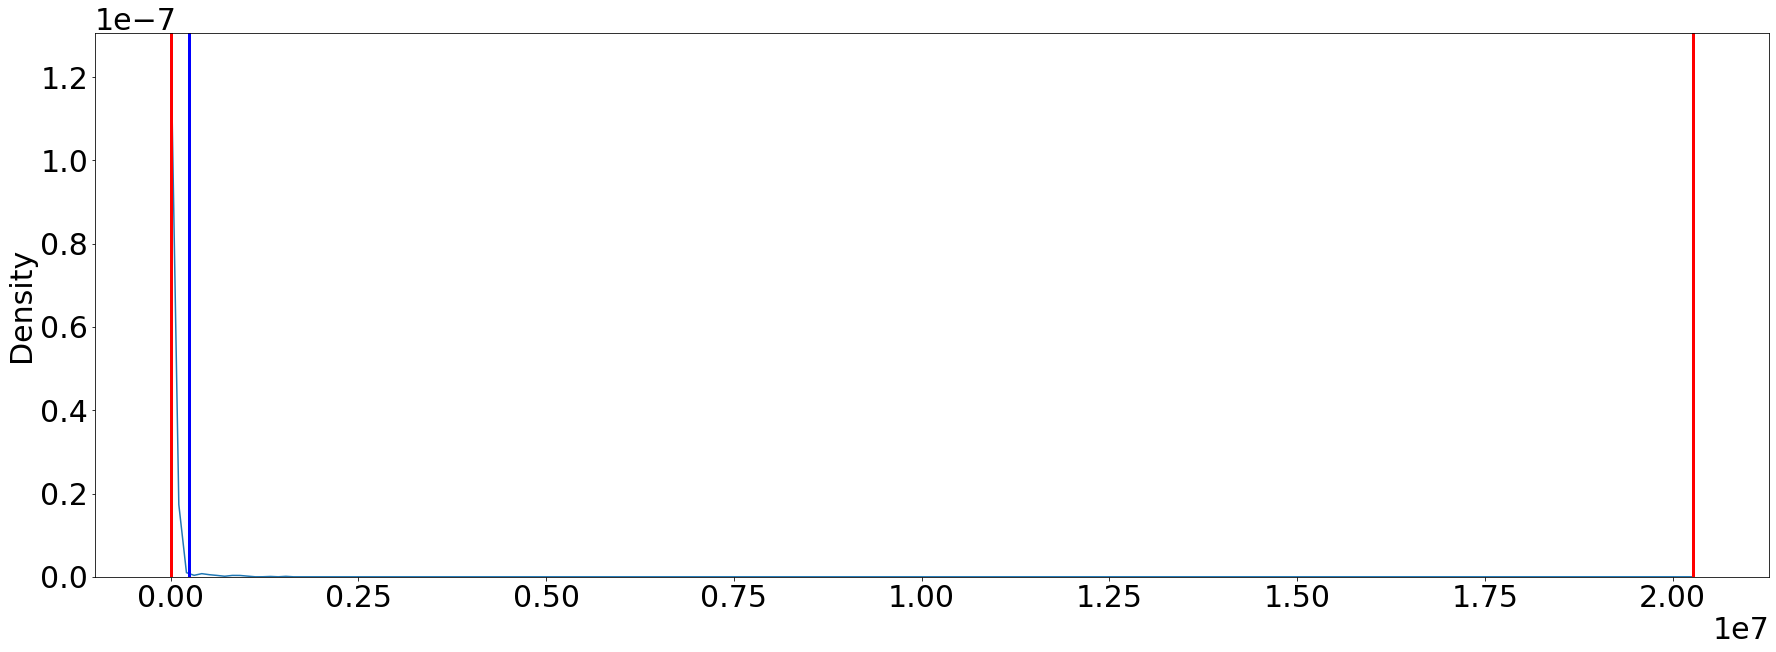

In [8]:
fig, ax = plt.subplots(figsize=(30,10))
sns.kdeplot(data=bws,ax=ax)
# ax.axvline(np.array(bws).mean(),c='g',lw=3)
ax.axvline(minbandwidth,c='r',lw=3)
ax.axvline(maxbandwidth,c='r',lw=3)
# ax.axvline(np.array(bws).mean()+3*np.array(bws).std(),c='b',lw=3)
# ax.axvline(0.125e6,c='b',lw=3)
ax.axvline(2.5e5,c='b',lw=3)

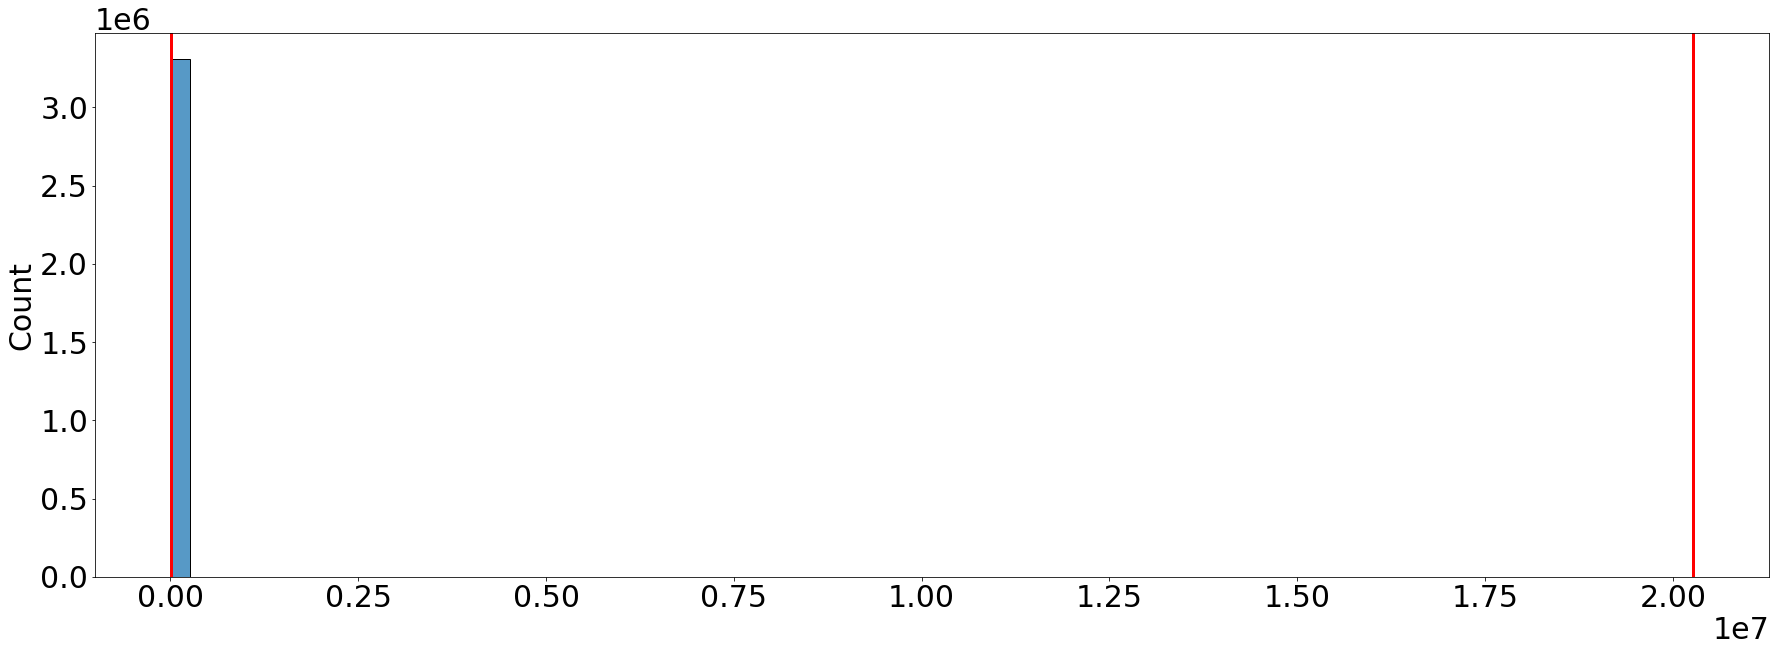

In [9]:
fig, ax = plt.subplots(figsize=(30,10))
sns.histplot(data=bws,ax=ax,bins=80)
ax.axvline(minbandwidth,c='r',lw=3)
ax.axvline(maxbandwidth,c='r',lw=3)

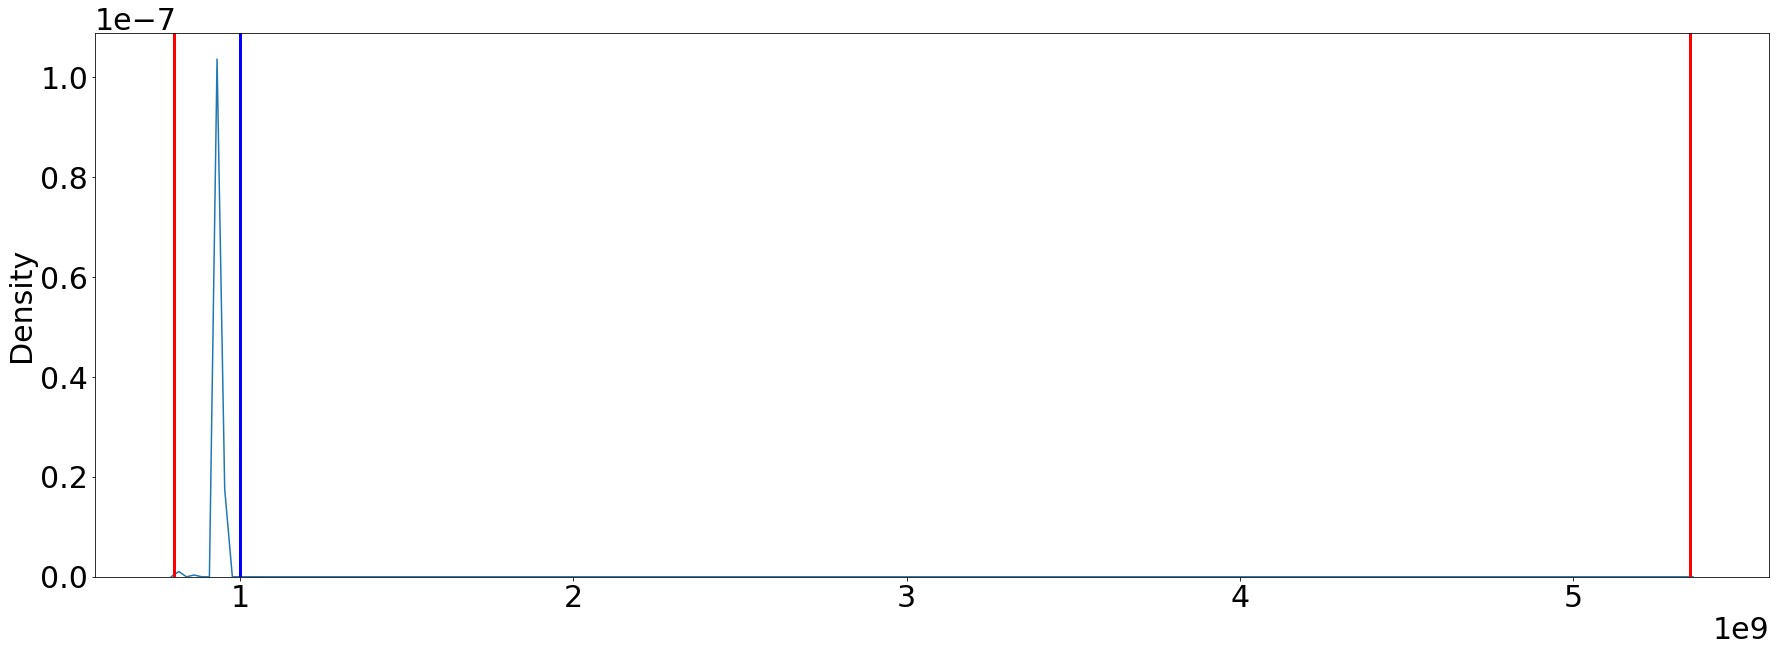

In [10]:
fig, ax = plt.subplots(figsize=(30,10))
sns.kdeplot(data=freqs,ax=ax)
ax.axvline(minfrequency,c='r',lw=3)
ax.axvline(maxfrequency,c='r',lw=3)
ax.axvline(1e9,c='b',lw=3)

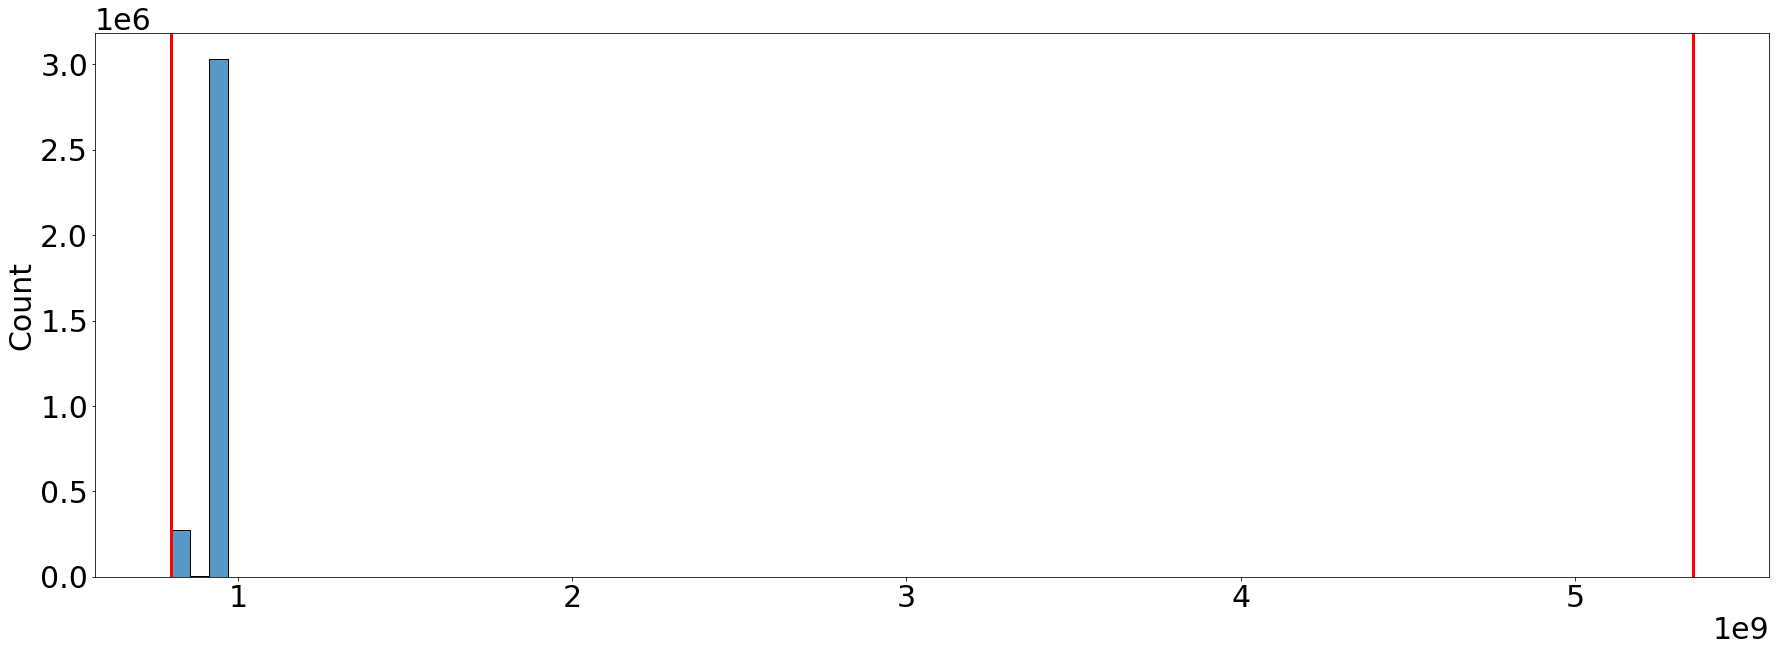

In [11]:
fig, ax = plt.subplots(figsize=(30,10))
sns.histplot(data=freqs,ax=ax,bins=80)
ax.axvline(minfrequency,c='r',lw=3)
ax.axvline(maxfrequency,c='r',lw=3)

In [36]:
#Dataset Hyperparameters

min_bw=minbandwidth
max_bw=2.5e5 #This is set manually (need to figure out how to set something like this properly)
# max_bw=23971334.69581604
min_freq= minfrequency
max_freq= 1e9
time_interval=2.5*60  #3 Minute Intervals (i.e., 180 seconds.)
date_format_string="%Y-%m-%dT%H:%M:%S.%fZ"

min_tstp=int(mintstp.strftime('%s')) #we only consider second level times as intervals are usually multiple seconds in length.
max_tstp=int(maxtstp.strftime('%s')) #we only consider second level times as intervals are usually multiple seconds in length.
NUMBINS_FREQ=80
NUMBINS_BW=80
NUM_TIME_BINS=int((max_tstp - min_tstp)/time_interval)

In [37]:
def get_bins(min_val,max_val,num_bins):
    val_range = (max_val - min_val)
    bin_size = val_range/num_bins
    return np.arange(min_val,max_val,bin_size),bin_size

freq_intervals,freq_binwidth=get_bins(min_freq,max_freq,num_bins=NUMBINS_FREQ)
bw_intervals,bw_binwidth=get_bins(min_bw,max_bw,num_bins=NUMBINS_BW)

In [38]:
def get_timebin(curr_timestamp,start_timestamp,time_interval,num_intervals):
    """
        @param curr_timestamp: The timestamp of the current time we want to bin.
        @param start_timestmap: The timestamp of the minimum time in our dataset.
        @param time_interval: The interval of time i.e., binwidth.
        @param num_intervals: The total number of time bins that are in use.
    """
    reltime = (int(curr_timestamp) - start_timestamp)   #int(curr_timestamp) converts any timestamp with milliseconds to seconds.
    timebin = math.floor(reltime/time_interval)   
    return min(timebin,num_intervals-1)

    
#Binning Logic
def _getbin(val,minval,binwidth,num_intervals):
    """
        @param val: (float) indicating the current value to be binned.
        @param minval: (float) indicating the minimum of the value calculated across all the packets.
        @param binwidth: (float) indicating the width of each bin.
        @param num_intervals: (float) the total number of intervals.
        @return: (integer) Indicating the bin index.
    """
    
    _bin = min(num_intervals-1,math.floor((val - minval)/binwidth))
    return _bin
    
def get_freqbin(curr_freq,min_freq,binwidth,num_intervals):
    """
        @param curr_freq: The frequency of the current packet to be binned. (float)
        @param min_freq: The minimum frequency calculated across all packets in the dataset. (float)
        @param binwidth: The width of each frequency bin. (float)
        @param num_intervals: The number of frequency bins considered in total. (integer)
        @return: (integer) Indicating the bin index for the frequency axis in which
                 to store the current packet information.
    """
    

    return _getbin(curr_freq,min_freq,binwidth,num_intervals)
    
def get_bandwidthbin(curr_bw,min_bw,binwidth,num_intervals):
    """
        @param curr_freq: The frequency of the current packet to be binned. (float)
        @param min_freq: The minimum frequency calculated across all packets in the dataset. (float)
        @param binwidth: The width of each frequency bin. (float)
        @param num_intervals: The number of frequency bins considered in total. (integer)
        @return: (integer) Indicating the bin index for the frequency axis in which
                 to store the current packet information.
    
    """
    return _getbin(curr_bw,min_bw,binwidth,num_intervals)


def bin_data(packets,minfreq,freq_binwidth,NUMBINS_FREQ,min_bw,bw_binwidth,NUMBINS_BW,
             mintstp,date_format_string,time_binwidth,NUM_TIME_BINS):
    
    """
        @param packets: List of json objects, each containing {'frequency':,'bandwidth':,'timestamp':}
        @param minfreq: (Float) indicating the minimum frequency across all packets in the dataset.
        @param freq_binwidth: The width of each frequency bin.
        @param min_bw: (Float) inidicating the minimum bandwidth across all packets in the dataset.
        @param bw_binwidth: The width of each bandwidth bin.
        @param NUMBINS: (Integer) indicating the number of frequency and bandwidth bins
        @param mintstp: (float) indicating the minimim timestamp across all packets.
        @param date_format_string: The date format string that all packet times will follow.
        @param time_binwidth: (float) the width of each time bin.
        @param NUM_TIME_BINS: (Integer) indicating the number of time bins.
    
    """
    
    #array of size (NUM_TIME_BINS,NUMFreqBins,NUMBWBins) in our case NUM{Frequency,Bandwidth}Bins are the same number.
    packet_counts = np.zeros((NUM_TIME_BINS,NUMBINS_FREQ,NUMBINS_BW))
#     packet_counts_non = np.zeros((NUM_TIME_BINS,NUMBINS_FREQ,NUMBINS_BW))
#     if anomalydata:
#         anom_count = np.zeros(NUM_TIME_BINS)
#         packet_counts_non = np.zeros((NUM_TIME_BINS,NUMBINS_FREQ,NUMBINS_BW))
#         freq_persignature = {}
    packet_timestamps = np.zeros(NUM_TIME_BINS)
    
    for idx,packet in enumerate(packets):
        freq=packet['frequency']
        bw=packet['bandwidth']
        tstp = parse(packet['timestamp']).timestamp()
        freqbin = get_freqbin(freq,min_freq,freq_binwidth,num_intervals=NUMBINS_FREQ) 
        bwbin = get_bandwidthbin(bw,min_bw,bw_binwidth,num_intervals=NUMBINS_BW)
        timebin = get_timebin(tstp,mintstp,time_binwidth,num_intervals=NUM_TIME_BINS)
        packet_timestamps[timebin] = tstp
        packet_counts[timebin][freqbin][bwbin]+=1
#         if anomalydata:
#             if packet['anomalyflag']==1:
#                 anom_count[timebin] += 1
#                 continue
#             packet_counts_non[timebin][freqbin][bwbin]+=1
#             if not tstp in freq_persignature.keys():
#                 freq_persignature[tstp] = []
#             freq_persignature[tstp].append(freq)
#     if anomalydata:
#         return packet_counts,packet_counts_non, anom_count, packet_timestamps, freq_persignature
    return packet_counts, packet_timestamps

In [39]:
# if anomalydata:
#     packet_counts,packet_counts_non,anom_count,packet_timestamps,freq_persignature = bin_data(packets,min_freq,freq_binwidth,NUMBINS_FREQ,min_bw,bw_binwidth,NUMBINS_BW,
#              min_tstp,date_format_string,time_interval,NUM_TIME_BINS)
# else:
packet_counts,packet_timestamps = bin_data(packets,min_freq,freq_binwidth,NUMBINS_FREQ,min_bw,bw_binwidth,NUMBINS_BW,min_tstp,date_format_string,time_interval,NUM_TIME_BINS)

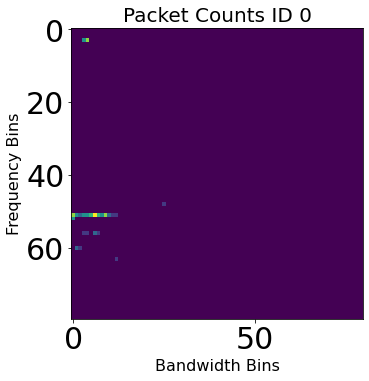

In [40]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
bar = ax.imshow(packet_counts[109])
ax.set_xlabel("Bandwidth Bins",fontsize=16)
ax.set_ylabel("Frequency Bins",fontsize=16)
ax.set_title("Packet Counts ID {}".format('0'),fontsize=20)
fig.tight_layout()

In [41]:
np.save('{}_signatures_maxbw25e4_maxfr1e9_150s.npy'.format('fm'),packet_counts)
np.save('{}_timestamps_maxbw25e4_maxfr1e9_150s.npy'.format('fm'),packet_timestamps)

In [49]:
for item in freq_persignature:
    freq_persignature[item] = max(freq_persignature[item])

In [50]:
with open('freq_persignature_p25.pkl','wb') as f:
    pickle.dump(freq_persignature,f)

In [52]:
np.save('/home/rgopikrishna/data/anomaly/FM_anomaly_signatures_maxbw1e5_try3.npy',packet_counts)
np.save('/home/rgopikrishna/data/anomaly/FM_nonanomaly_signatures_maxbw1e5_try3.npy',packet_counts_non)
np.save('/home/rgopikrishna/data/anomaly/FM_anomaly_anomcounts_maxbw1e5_try3.npy',np.array(anom_count))
np.save('/home/rgopikrishna/data/anomaly/FM_anomaly_timestamps_maxbw1e5_try3.npy',np.array(packet_timestamps))

In [13]:
# np.save('/home/rgopikrishna/data/anomaly/P25_signatures_maxbw1e5_fromfmanomalyfile.npy',packet_counts)

In [23]:
anom_idx = 0 
for idx,i in enumerate(anom_count):
    if i>0:
        print(idx)
        anom_idx = idx

2224


In [ ]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
bar = ax.imshow(packet_counts[0])
ax.set_xlabel("Bandwidth Bins",fontsize=16)
ax.set_ylabel("Frequency Bins",fontsize=16)
ax.set_title("Packet Counts ID {}".format('0'),fontsize=20)
fig.tight_layout()
# fig.savefig("{}/packet".format('/home/rgopikrishna/data/anomaly'),dpi=300)

In [27]:
print(np.sum(packet_counts_non[2224]))
print(np.sum(packet_counts[2224]))

1125.0
1191.0


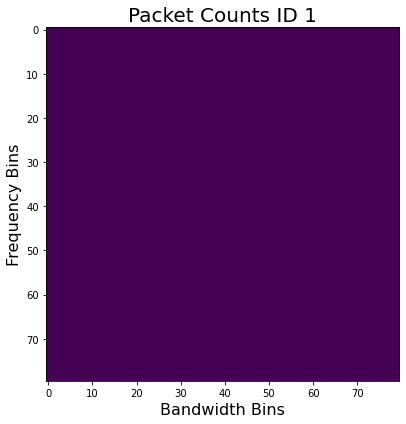

In [38]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
bar = ax.imshow(packet_counts[0])
ax.set_xlabel("Bandwidth Bins",fontsize=16)
ax.set_ylabel("Frequency Bins",fontsize=16)
ax.set_title("Packet Counts ID {}".format(1),fontsize=20)
fig.tight_layout()

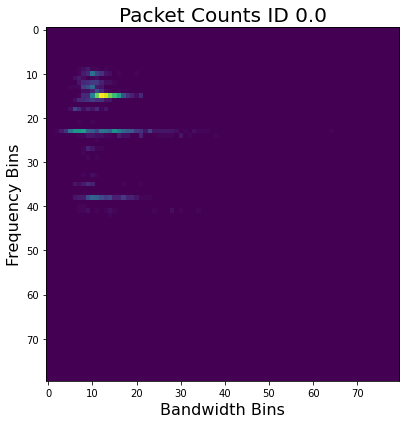

In [16]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
bar = ax.imshow(packet_counts[anom_idx+1])
ax.set_xlabel("Bandwidth Bins",fontsize=16)
ax.set_ylabel("Frequency Bins",fontsize=16)
ax.set_title("Packet Counts ID {}".format(i),fontsize=20)
fig.tight_layout()

In [17]:
packet_timestamps[0]

1602275145.885354